In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import yfinance as yf


In [2]:
#Load and preprocess the data
data = yf.download('RELIANCE.NS', start='2015-01-01', end='2023-05-05')
data = data.dropna()
training_data = data.iloc[:, 3:4].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(training_data)


[*********************100%***********************]  1 of 1 completed


In [3]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,438.988831,441.812073,437.676270,439.781311,417.988892,1367720
2015-01-02,439.880371,443.818054,437.998199,438.617340,416.882629,3383424
2015-01-05,438.344940,441.267212,432.946106,433.812897,412.316223,4662967
2015-01-06,430.915344,432.401276,412.093750,414.124512,393.603424,8596809
2015-01-07,414.619812,425.367950,414.570282,423.139069,402.171326,9562421
...,...,...,...,...,...,...
2023-04-27,2375.000000,2384.000000,2364.000000,2377.050049,2377.050049,4230627
2023-04-28,2382.000000,2423.899902,2381.750000,2420.500000,2420.500000,7183342
2023-05-02,2436.199951,2445.800049,2428.100098,2441.050049,2441.050049,5991101


In [4]:
training_data = data.iloc[:, 3:4].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(training_data)

In [5]:
# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

In [6]:
# Define the training and testing data sets
def create_dataset(data_set, time_steps=1):
   dataX, dataY = [], []
   for i in range(len(data_set)-time_steps-1):
       a = data_set[i:(i+time_steps), 0]
       dataX.append(a)
       dataY.append(data_set[i + time_steps, 0])
   return np.array(dataX), np.array(dataY)

In [7]:
time_steps = 60
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

In [8]:
# Reshape the input data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [10]:
# Compile and fit the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
50/50 [==============================] - 23s 156ms/step - loss: 0.0098
Epoch 2/50
50/50 [==============================] - 7s 147ms/step - loss: 0.0018
Epoch 3/50
50/50 [==============================] - 3s 64ms/step - loss: 0.0017
Epoch 4/50
50/50 [==============================] - 3s 65ms/step - loss: 0.0014
Epoch 5/50
50/50 [==============================] - 4s 90ms/step - loss: 0.0012
Epoch 6/50
50/50 [==============================] - 3s 64ms/step - loss: 0.0012
Epoch 7/50
50/50 [==============================] - 3s 65ms/step - loss: 0.0010
Epoch 8/50
50/50 [==============================] - 4s 76ms/step - loss: 0.0012
Epoch 9/50
50/50 [==============================] - 4s 74ms/step - loss: 0.0010
Epoch 10/50
50/50 [==============================] - 3s 64ms/step - loss: 9.9367e-04
Epoch 11/50
50/50 [==============================] - 3s 63ms/step - loss: 8.8133e-04
Epoch 12/50
50/50 [==============================] - 4s 87ms/step - loss: 8.9733e-04
Epoch 13/50
50/50 [===

In [11]:
# Make predictions on the test data and invert the scaling
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

11/11 [==============================] - 1s 19ms/step


In [12]:
# Convert the date index of the test data to a list of strings
date_index = data.index[train_size + time_steps + 1:len(data)]
date_strings = [date.strftime('%Y-%m-%d') for date in date_index]

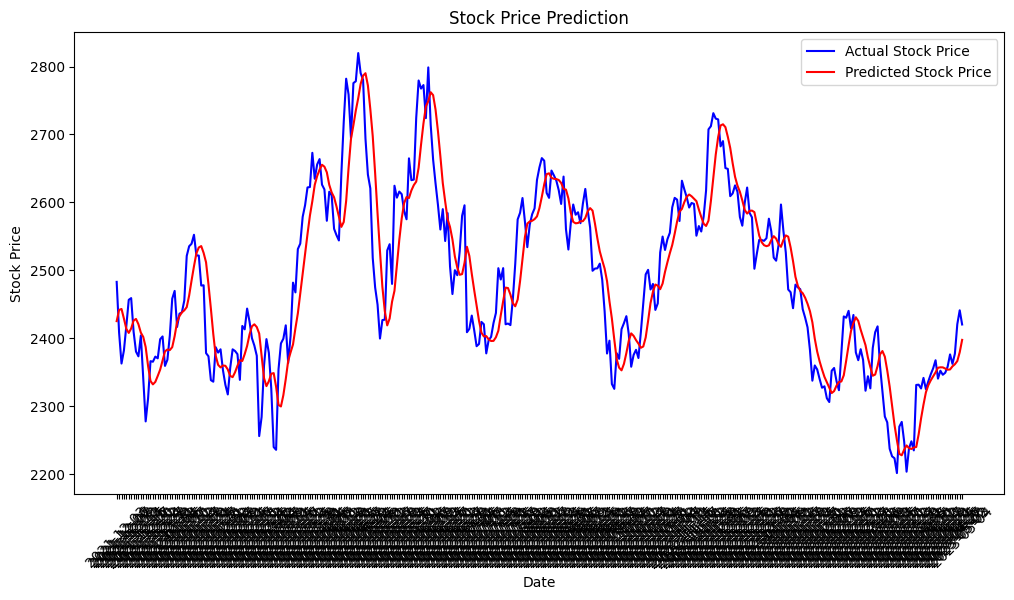

In [13]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(date_strings, y_test, color='blue', label='Actual Stock Price')
plt.plot(date_strings, y_pred, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [14]:
rsme= mean_squared_error(y_test, y_pred, squared=False)
mape= mean_absolute_percentage_error(y_test, y_pred)
print("RSME:",rsme)
print("MAPE:", mape)

RSME: 57.468405997094266
MAPE: 0.01825654024729153


In [15]:
# Forecast future stock prices
future_time_steps = 30  # Number of future time steps to forecast
last_sequence = X_test[-1]  # Last sequence from the test data


In [16]:
future_predictions = []  # Store future predictions

In [17]:
for _ in range(future_time_steps):
    # Reshape and predict the next time step
    last_sequence = last_sequence.reshape(1, time_steps, 1)
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred[0, 0])  # Append the predicted value

    # Update the last sequence with the new prediction
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_pred



1/1 [==============================] - 0s 27ms/step


In [18]:
# Invert scaling for future predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [19]:
#Prepare plot data
date_strings = [date.strftime('%Y-%m-%d') for date in data.index[train_size + time_steps + 3:]]
x_actual = range(len(y_test))
x_pred = range(len(y_test), len(y_test) + len(y_pred))
x_future = range(len(y_test) + len(y_pred), len(y_test) + len(y_pred) + len(future_predictions))

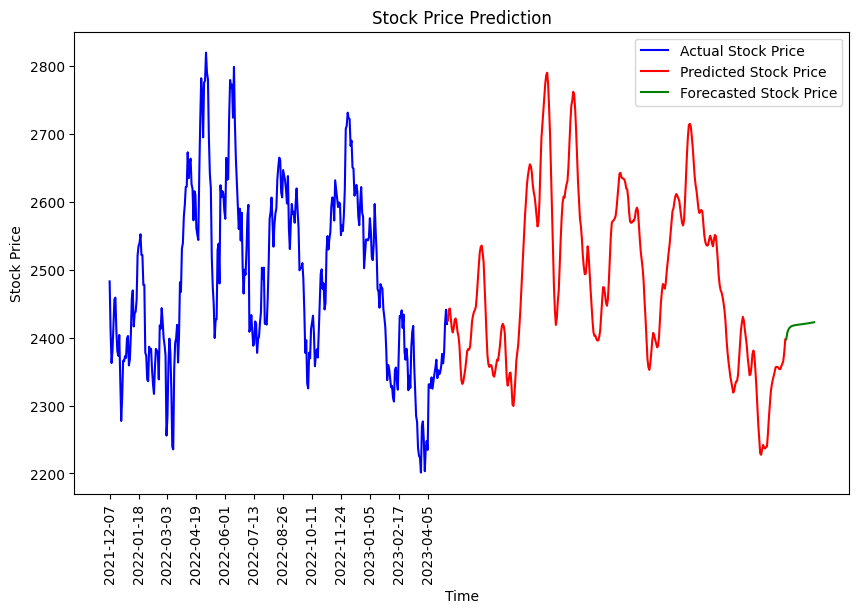

In [22]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_actual, y_test, color='blue', label='Actual Stock Price')
plt.plot(x_pred, y_pred, color='red', label='Predicted Stock Price')
plt.plot(x_future, future_predictions, color='green', label='Forecasted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(ticks=range(0, len(date_strings), 30), labels=date_strings[::30], rotation=90)
plt.legend()
plt.show()

In [21]:
# make predictions for the next 10 days
future_data = data.filter(['Close'])
last_60_days = future_data[-60:]
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_prices = []
for i in range(10):
    predicted_price = model.predict(X_test)
    predicted_prices.append(predicted_price[0][0])
    X_test = np.append(X_test, [predicted_price], axis=1)

# invert the scaling
predicted_prices = np.array(predicted_prices).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predicted_prices)

# print the predicted prices
print(predicted_prices)

1/1 [==============================] - 0s 30ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step
[[2424.6206]
 [2431.5955]
 [2435.3977]
 [2437.5833]
 [2438.897 ]
 [2439.7107]
 [2440.2222]
 [2440.5427]
 [2440.741 ]
 [2440.8613]]


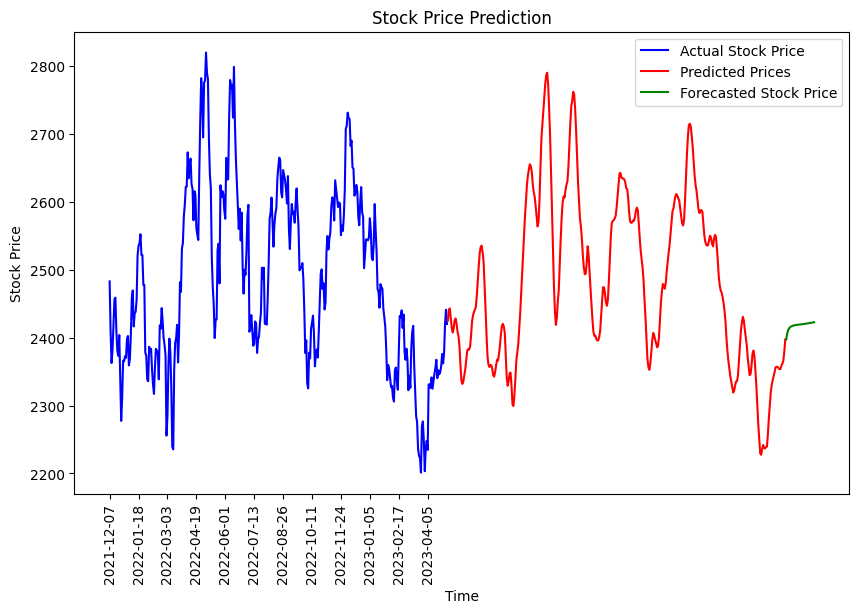

In [23]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_actual, y_test, color='blue', label='Actual Stock Price')
plt.plot(x_pred, y_pred, color='red', label='Predicted Prices')
plt.plot(x_future, future_predictions, color='green', label='Forecasted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(ticks=range(0, len(date_strings), 30), labels=date_strings[::30], rotation=90)
plt.legend()
plt.show()